#### Import các thư viện cần thiết

In [1]:
!pip install Unidecode

In [2]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Tải bộ dữ liệu

In [3]:
dataset_path = '/content/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(
    dataset_path,
    names=headers,
    encoding='ISO-8859-1'
)

In [4]:
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])
df

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,1,LONDON MarketWatch -- Share prices ended lower...
4842,0,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,1,Operating profit fell to EUR 35.4 mn from EUR ...
4844,1,Net sales of the Paper segment decreased to EU...


#### Tiền xử lý dữ liệu

In [5]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[~\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    return text

In [6]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))

#### Xây dựng bộ từ vựng

In [7]:
vocab = []
for sentence in df['content'].tolist():
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

# save vocab
import pickle
with open('vocabulary.pkl', 'wb') as file:
    pickle.dump(vocab, file)

In [8]:
def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_idx = word_to_idx(w)
        except:
            w_idx = word_to_idx['UNK']
        tokens.append(w_idx)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens))
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]

    return tokens

#### Chia bộ dữ liệu train, val, test

In [9]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

#### Xây dựng pytorch dataset

In [10]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform


    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(
                text,
                self.word_to_idx,
                self.max_seq_len
            )
        text = torch.tensor(text)
        return text, label

#### Khai báo dataloader

In [11]:
max_seq_len = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

#### Xây dựng mô hình

In [12]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim,
                 hidden_size, n_layers, n_classes,
                 dropout_prob):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [13]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

#### Hàm loss và optimizer

In [14]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

#### Huấn luyện mô hình

In [15]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

    return train_losses, val_losses

In [16]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc

In [17]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs
)

# save model
torch.save(model.state_dict(), 'sentiment_analysis_model.pt')

EPOCH 1:	Train loss: 1.0441	Val loss: 0.9493
EPOCH 2:	Train loss: 0.9463	Val loss: 0.9387
EPOCH 3:	Train loss: 0.9393	Val loss: 0.9325
EPOCH 4:	Train loss: 0.9311	Val loss: 0.9313
EPOCH 5:	Train loss: 0.9314	Val loss: 0.9298
EPOCH 6:	Train loss: 0.9334	Val loss: 0.9300
EPOCH 7:	Train loss: 0.9352	Val loss: 0.9292
EPOCH 8:	Train loss: 0.9310	Val loss: 0.9295
EPOCH 9:	Train loss: 0.9305	Val loss: 0.9296
EPOCH 10:	Train loss: 0.9301	Val loss: 0.9291
EPOCH 11:	Train loss: 0.9333	Val loss: 0.9294
EPOCH 12:	Train loss: 0.9302	Val loss: 0.9290
EPOCH 13:	Train loss: 0.9293	Val loss: 0.9295
EPOCH 14:	Train loss: 0.9303	Val loss: 0.9290
EPOCH 15:	Train loss: 0.9317	Val loss: 0.9291
EPOCH 16:	Train loss: 0.9304	Val loss: 0.9289
EPOCH 17:	Train loss: 0.9328	Val loss: 0.9289
EPOCH 18:	Train loss: 0.9305	Val loss: 0.9289
EPOCH 19:	Train loss: 0.9345	Val loss: 0.9289
EPOCH 20:	Train loss: 0.9284	Val loss: 0.9292
EPOCH 21:	Train loss: 0.9289	Val loss: 0.9293
EPOCH 22:	Train loss: 0.9295	Val loss: 0.92

Text(0.5, 1.0, 'Val Loss')

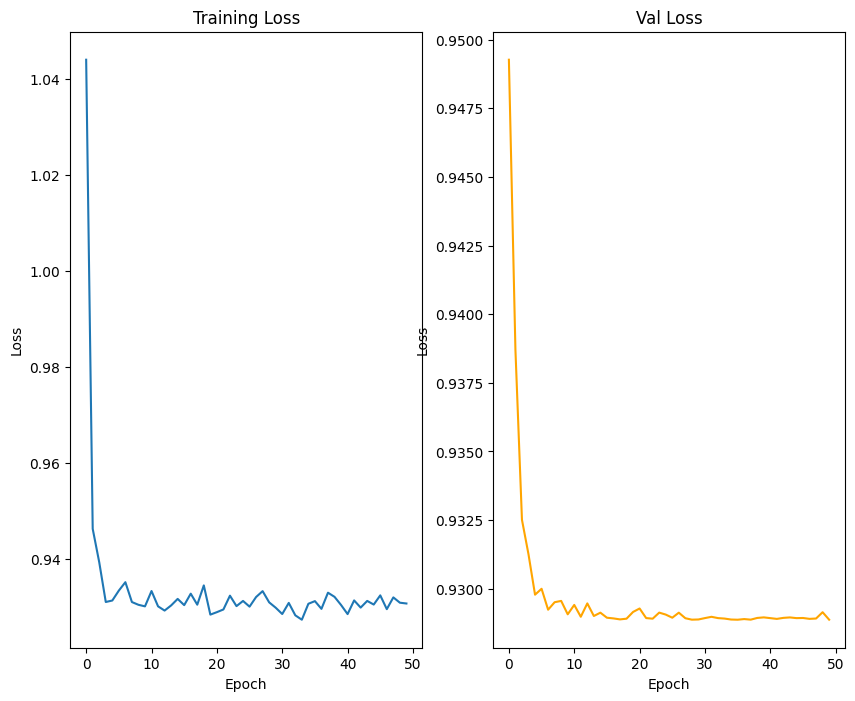

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].plot(train_losses)
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Training Loss')

ax[1].plot(val_losses, color='orange')
ax[1].set(xlabel='Epoch', ylabel='Loss')
ax[1].set_title('Val Loss')

#### Đánh giá mô hình

In [19]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluate on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluate on val/test dataset
Val accuracy:  0.5876288659793815
Test accuracy:  0.622680412371134
